<H3>Pipeline to Design Novel AMPs Using Proposed Models
   

In [1]:
"""
1) embed an existing AMP (GL13K: GKIIKLKASLKLL )
2) sample the latent space near the amp
3) decode 5 sequences from that region for each model
4) analyze the sequences
"""

'\n1) embed an existing AMP (GL13K: GKIIKLKASLKLL )\n2) sample the latent space near the amp\n3) decode 5 sequences from that region for each model\n4) analyze the sequences\n'

<H3> Insert AMP of interest below

In [2]:
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *
import glob
import re
import os
import random
from sklearn.decomposition import PCA

amp_of_interest = "GKIIKLKASLKLL"

gpu = True

num_sequences = 500_000 #how many sequences from the dataset to look at
batch_size = 500 #setting for reconstruction
example_data = 'data\\peptide_test.txt'
save_dir_loc = 'model_analyses\\sample\\' #folder in which to save outpts
save_dir_name = 'pipeline' #appended to identify data: train|test|other|etc...

recon_src = "checkpointz//analyses_ckpts//" #directory in which all reconstructions are stored
true_prop_src = 'data\\function_test.txt' #if property predictor load the true labels

ckpt_list = glob.glob(""+"checkpointz\\to_slurm//**//*.ckpt", recursive = True) #grab all checkpoint
print('current working directory: ',os.getcwd())

for i in range(len(ckpt_list)):
    
    #search the current directory for the model name and load that model
    model_dic = {'trans':'TransVAE','aae':'AAE','rnnattn':'RNNAttn','rnn':'RNN','wae':'WAE'}
    model_src = ckpt_list[i]
    print('working on: ',model_src,'\n')
    model_name = list(filter(None,[key for key in model_dic.keys() if key in model_src.split('\\')[-1]]))
    model = locals()[model_dic[model_name[0]]](load_fn=model_src) #use locals to call model specific constructor
    model.params['BATCH_SIZE'] = batch_size #adjusted for 1 sequence inputs
    
    #create save directory for the current model according to latent space size
    latent_size = re.findall('(latent[\d]{2,3})', model_src)
    save_dir= save_dir_loc+model.name+"_"+latent_size[0]+"_"+save_dir_name
    if not os.path.exists(save_dir):os.mkdir(save_dir) 
    save_dir= save_dir+"//" 
    save_df = pd.DataFrame() #this will hold the number variables and save to CSV
    
    #load the true labels
    data = pd.read_csv(example_data).to_numpy() 
    data_1D = data[:num_sequences,0] #gets rid of extra dimension
    true_props_data = pd.read_csv(true_prop_src).to_numpy()
    true_props = true_props_data[0:num_sequences,0]
    
    #moving test data into memory
    if model.model_type =='aae':
        mus, _, _ = model.calc_mems(data[:65_000], log=False, save=False) #65K covers the test set (~60k)
    elif model.model_type == 'wae':
        mus, _, _ = model.calc_mems(data[:65_000], log=False, save=False) 
    else:
        mems, mus, logvars = model.calc_mems(data[:65_000], log=False, save=False)

    #plug the reference amp into the latent space
    model.params['BATCH_SIZE'] = 1 #adjusted for 1 sequence inputs
    reference_amp = np.array([amp_of_interest]).reshape(1,1)
    ref_mems, ref_mus, ref_logvars = model.calc_mems(reference_amp,log=False, save=False)
    
    #perform pca on all test data and amp of interest
    pca = PCA(n_components=mus.shape[1],svd_solver='full')
    pca_batch =pca.fit_transform(X=np.append(mus, ref_mems, axis=0)) #adding our sequence to the training set of PCA for better transforms on our sequence
    ref_pca = pca.transform(ref_mems)


current working directory:  c:\Users\sam\Documents\GitHub\latent-spaces-amps
working on:  checkpointz\to_slurm\trans_latent128\300_trans1x-128_peptide.ckpt 



In [3]:
subsample_start=0
subsample_length=mus.shape[0] #mus shape depends on batch size!
#this is for plots:
#(for length based coloring): record all peptide lengths iterating through input
pep_lengths = []
for idx, pep in enumerate(data[subsample_start:(subsample_start+subsample_length)]):
    pep_lengths.append( len(pep[0]) )   
#(for function based coloring): pull function from csv with peptide functions
s_to_f =pd.read_csv(true_prop_src)    
function = s_to_f['peptides'][subsample_start:(subsample_start+subsample_length)]

In [4]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

amp_pc_correlations = [spearmanr(pca_batch[:-1,pc],function).correlation for pc in range(5)]
top_amp_pc = np.argmax(np.abs(amp_pc_correlations))

phys_props = pd.read_csv('data\\new_test_physicochem_props.csv')
phys_chem_name = 'hydrophobicity'
phys_chem_prop = phys_props[phys_chem_name][:len(mus)].values
hydrophic_pc_correlations= [pearsonr(pca_batch[:-1,pc],phys_chem_prop) for pc in range(5)]
top_property_pc = np.argmax(np.abs(hydrophic_pc_correlations))

In [20]:
#adding noise to the mean latent vector of our sequence
noise_factor=0.5 #adjust the noise magnitude
sample_count=300 #number of latent points to sample
noisy_vector = np.zeros(shape=(sample_count, 1, ref_pca.shape[1])).astype(np.float32)
noise = np.abs(np.random.normal(loc=0,scale=1,size=(sample_count,1)))
noisy_vector[:,:,top_amp_pc] += np.random.normal(loc=0, scale=1, size=(noise.shape))#+noise  
noisy_vector[:,:,top_property_pc] +=  np.random.normal(loc=0, scale=1, size=(noise.shape))#+noise
nearby_samples = noisy_vector*noise_factor+ref_pca

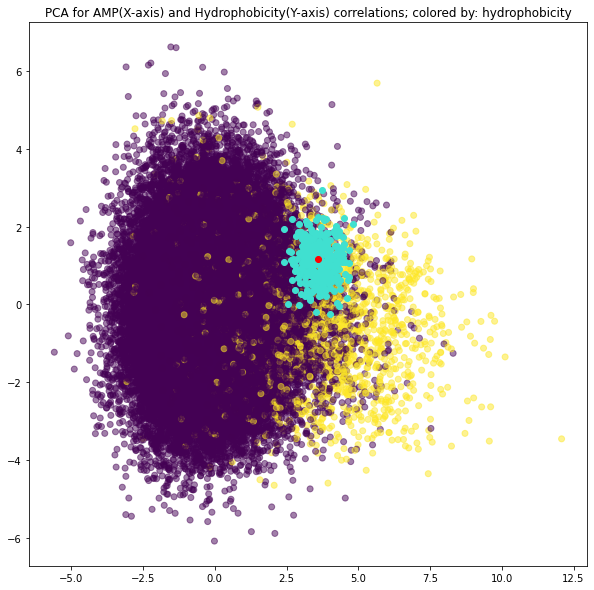

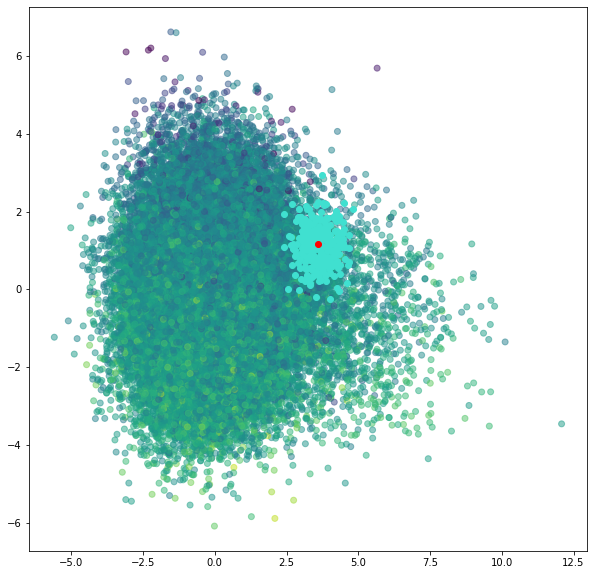

In [21]:
#Plots of AMP PC's, mean latent and noise samples
plt.figure(figsize=(10,10))
plt.title('PCA for AMP(X-axis) and Hydrophobicity(Y-axis) correlations; colored by: AMP(y), non-amp(p)')
plt.scatter(pca_batch[:, top_amp_pc], pca_batch[:,top_property_pc], c=pd.concat([function, pd.DataFrame([1])]), alpha=0.5)
plt.scatter(nearby_samples[:,0, top_amp_pc], nearby_samples[:,0, top_property_pc], color='turquoise', alpha=1)
plt.scatter(ref_pca[:, top_amp_pc], ref_pca[:, top_property_pc], color='red', alpha=1)

plt.title('PCA for AMP(X-axis) and Hydrophobicity(Y-axis) correlations; colored by: hydrophobicity')
plt.figure(figsize=(10,10))
plt.scatter(pca_batch[:, top_amp_pc], pca_batch[:,top_property_pc], c=np.append(phys_chem_prop, 0), alpha=0.5)
plt.scatter(nearby_samples[:,0, top_amp_pc], nearby_samples[:,0, top_property_pc], color='turquoise', alpha=1)
plt.scatter(ref_pca[:, top_amp_pc], ref_pca[:, top_property_pc], color='red', alpha=1)


In [24]:
noise.shape, ref_pca.shape

((300, 1), (1, 128))

In [22]:
decoded_rnd_seqs=[amp_of_interest]
while len(set(decoded_rnd_seqs))<6:
    model.params['BATCH_SIZE'] = 300 #adjusted for 1 sequence inputs
    noisy_vector = np.zeros(shape=(sample_count, 1, ref_pca.shape[1])).astype(np.float32)
    noise = np.random.normal(loc=0,scale=1,size=(sample_count,1))
    noisy_vector[:,:,top_amp_pc] += np.random.normal(loc=0, scale=1, size=(noise.shape))#+noise
    noisy_vector[:,:,top_property_pc] += np.random.normal(loc=0, scale=1, size=(noise.shape))#+noise
    #reverse the PCA transform on the nearby PCA points
    latent_nearby_samples = pca.inverse_transform(noisy_vector*noise_factor+ref_pca)
    #throw latent points into decoder
    rnd_token_list=np.empty((sample_count,model.tgt_len)) #store N decoded latent vectors now in token(0-20) form max length 125
    #latent_nearby_samples=ref_mems #<-- uncomment this to see what the if the model correctly reconstruct the original input sequence before sampling nearby
    #latent_nearby_samples=pca.inverse_transform(ref_pca)
    rnd_token_list =  model.greedy_decode(torch.tensor(latent_nearby_samples.squeeze(1)).cuda())
    decoded_rnd_seqs.extend(decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT']))


decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100


<ipython-input-22-1fad973491b2>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_rnd_seqs.extend(decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT']))


decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100


In [ ]:
torch.cuda.empty_cache() #free allocated CUDA memory

In [19]:
#print out the 5 sampled sequences and the amp of interest
set(decoded_rnd_seqs) ,  "GKIIKLKASLKLL"

({'GKIIKLKASKLLK', 'GKIIKLKASLKLL', 'GKIILKKALSKLL', 'GKIILKKASLKLL'},
 'GKIIKLKASLKLL')

In [ ]:
#keep only unique sequences
decoded_rnd_seqs = list(set(decoded_rnd_seqs))

<H3> Sequence Analysis Section (Not necessary for pipeline)

In [ ]:
import peptides #physicochemical analysis tool
dict_list=[]

for seq in decoded_rnd_seqs:
    pep = peptides.Peptide(seq)
    dict_list.append(
        {"aliphatic_index":pep.aliphatic_index(),
     "boman":pep.boman(),
     "charge_ph3":pep.charge(pH=3)/len(seq[0]),
     "charge_ph7":pep.charge(pH=7)/len(seq[0]),
     "charge_ph11":pep.charge(pH=11)/len(seq[0]),
    "hydrophobicity":pep.hydrophobicity(),
    "instability_index":pep.instability_index(),
    "isoelectric_point":pep.isoelectric_point(),
    "molecular_weight":pep.molecular_weight(),
    "seq":seq} )

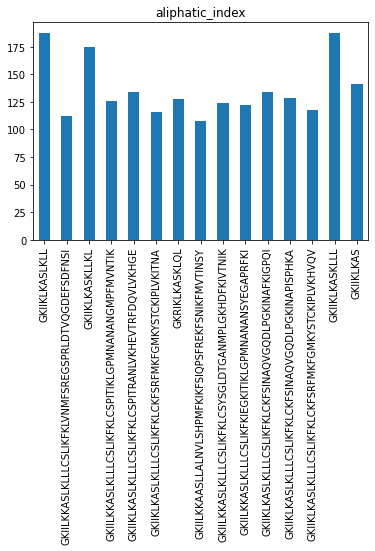

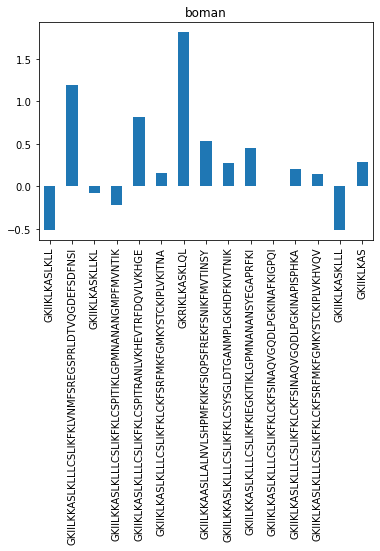

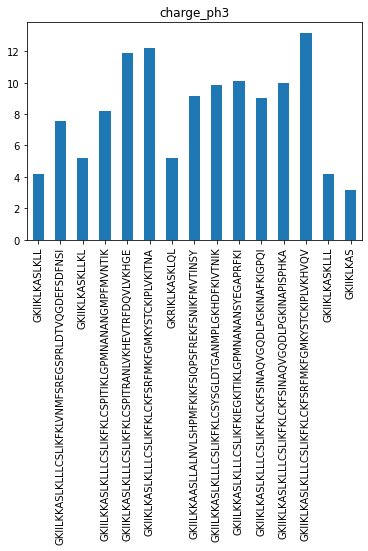

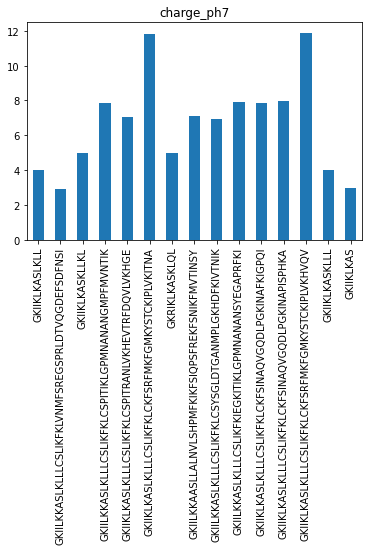

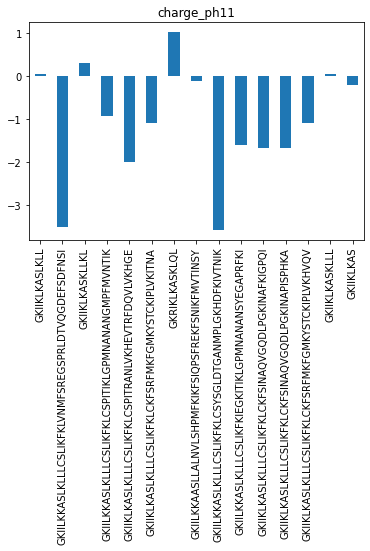

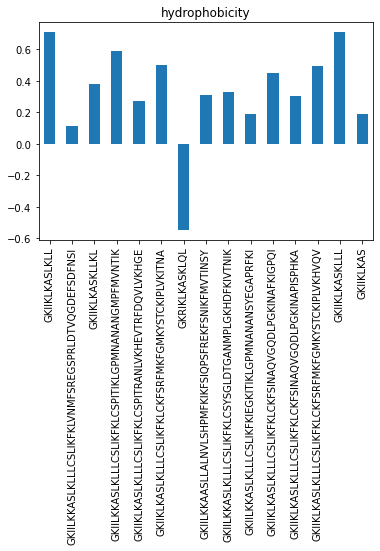

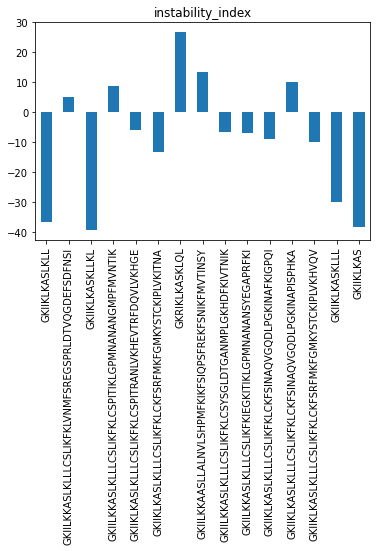

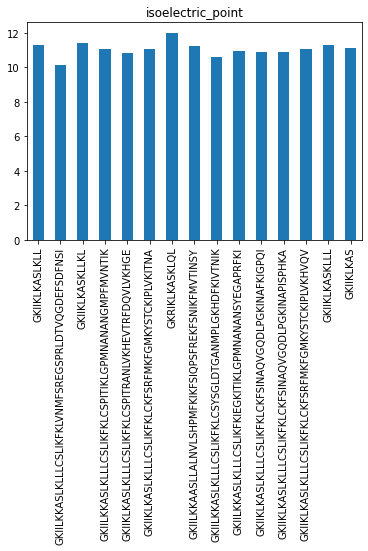

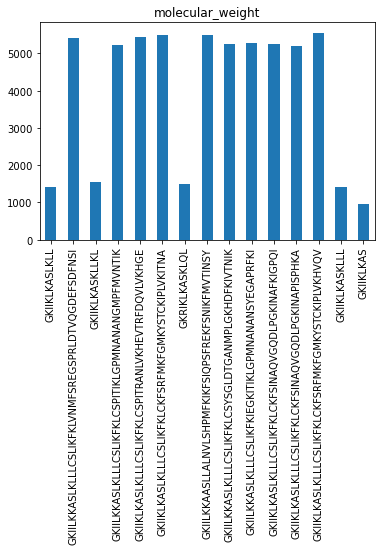

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

analysis_df = pd.DataFrame(dict_list)
for idx,col in enumerate(analysis_df.columns):
    if col == 'seq': break
    plt.figure()
    analysis_df[col].plot(kind='bar')
    plt.title(col)
    plt.xticks(np.linspace(0,len(decoded_rnd_seqs)-1,num=len(decoded_rnd_seqs)),labels=analysis_df['seq'])
    plt.savefig(save_dir+"{}.png".format(col),facecolor='white',transparent=None,bbox_inches='tight', dpi=600)

with open(save_dir+'seqs.txt', 'w') as f:
    for seq in decoded_rnd_seqs:
        f.write(seq)
        f.write("\n")
f.close()


<H3> Extra: dealing with PCA accuracy

In [168]:
#pca.inverse_transform(ref_pca), ref_mems, pca.inverse_transform(ref_pca)-ref_mems #checking that PCA is accurately inverse transforming the latent vector of our original sample

<H3> it turns out that if the n_components of PCA are set to 5 which was the number of PC's we cared about PCA does not perfectly reconstruct the Latent 128 dimensional vector and so it is nearly impossible to obtain the original AMP using a latent space traversal!

Instead we should keep PCA n_components at 128 but look at only the first 5 PC's

<H3> This section is to run the pipeline on different model checkpoints in series

In [ ]:
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *
import glob
import re
import os
import random
from sklearn.decomposition import PCA

amp_of_interest = "GKIIKLKASLKLL"

gpu = True

num_sequences = 500_000 #how many sequences from the dataset to look at
batch_size = 500 #setting for reconstruction
example_data = 'data\\peptide_test.txt'
save_dir_loc = 'model_analyses\\sample\\' #folder in which to save outpts
save_dir_name = 'pipeline' #appended to identify data: train|test|other|etc...

recon_src = "checkpointz//analyses_ckpts//" #directory in which all reconstructions are stored
true_prop_src = 'data\\function_test.txt' #if property predictor load the true labels

ckpt_list = glob.glob(""+"checkpointz\\to_slurm//**//*.ckpt", recursive = True) #grab all checkpoint
print('current working directory: ',os.getcwd())

for i in range(len(ckpt_list)):
    
    #search the current directory for the model name and load that model
    model_dic = {'trans':'TransVAE','aae':'AAE','rnnattn':'RNNAttn','rnn':'RNN','wae':'WAE'}
    model_src = ckpt_list[i]
    print('working on: ',model_src,'\n')
    model_name = list(filter(None,[key for key in model_dic.keys() if key in model_src.split('\\')[-1]]))
    model = locals()[model_dic[model_name[0]]](load_fn=model_src) #use locals to call model specific constructor
    model.params['BATCH_SIZE'] = batch_size #adjusted for 1 sequence inputs
    
    #create save directory for the current model according to latent space size
    latent_size = re.findall('(latent[\d]{2,3})', model_src)
    save_dir= save_dir_loc+model.name+"_"+latent_size[0]+"_"+save_dir_name
    if not os.path.exists(save_dir):os.mkdir(save_dir) 
    save_dir= save_dir+"//" 
    save_df = pd.DataFrame() #this will hold the number variables and save to CSV
    
    #load the true labels
    data = pd.read_csv(example_data).to_numpy() 
    data_1D = data[:num_sequences,0] #gets rid of extra dimension
    true_props_data = pd.read_csv(true_prop_src).to_numpy()
    true_props = true_props_data[0:num_sequences,0]
    
    #moving test data into memory
    if model.model_type =='aae':
        mus, _, _ = model.calc_mems(data[:65_000], log=False, save=False) #65K covers the test set (~60k)
    elif model.model_type == 'wae':
        mus, _, _ = model.calc_mems(data[:65_000], log=False, save=False) 
    else:
        mems, mus, logvars = model.calc_mems(data[:65_000], log=False, save=False)

    #plug the reference amp into the latent space
    model.params['BATCH_SIZE'] = 1 #adjusted for 1 sequence inputs
    reference_amp = np.array([amp_of_interest]).reshape(1,1)
    ref_mems, ref_mus, ref_logvars = model.calc_mems(reference_amp,log=False, save=False)
    
    #perform pca on all test data and amp of interest
    pca = PCA(n_components=mus.shape[1],svd_solver='full')
    pca_batch =pca.fit_transform(X=np.append(mus, ref_mems, axis=0)) #adding our sequence to the training set of PCA for better transforms on our sequence
    ref_pca = pca.transform(ref_mems)

    # subsample_start=0
    # subsample_length=mus.shape[0] #mus shape depends on batch size!
    # #this is for plots:
    # #(for length based coloring): record all peptide lengths iterating through input
    # pep_lengths = []
    # for idx, pep in enumerate(data[subsample_start:(subsample_start+subsample_length)]):
    #     pep_lengths.append( len(pep[0]) )   
    # #(for function based coloring): pull function from csv with peptide functions
    # s_to_f =pd.read_csv(true_prop_src)    
    # function = s_to_f['peptides'][subsample_start:(subsample_start+subsample_length)]
    
    # #adding noise to the mean latent vector of our sequence
    # noise_factor=0.1 #adjust the noise magnitude
    # sample_count=5 #number of latent points to sample
    # nearby_samples = np.random.normal(loc=0,scale=1,size=(sample_count,1,ref_pca.shape[1])).astype(np.float32)*noise_factor + ref_pca

    # # #Plots of AMP PC's, mean latent and noise samples
    # # plt.figure(figsize=(10,10))
    # # plt.scatter(pca_batch[:, 3], pca_batch[:, 4], c=pd.concat([function, pd.DataFrame([1])]), alpha=0.5)
    # # plt.scatter(nearby_samples[:,0, 3], nearby_samples[:,0, 4], color='turquoise', alpha=1)
    # # plt.scatter(ref_pca[:, 3], ref_pca[:, 4], color='red', alpha=1)
    # # plt.savefig(save_dir+"latents_w_samples.png")

    # #reverse the PCA transform on the nearby PCA points
    # latent_nearby_samples = pca.inverse_transform(nearby_samples)
    # #throw latent points into decoder
    # rnd_token_list=np.empty((sample_count,model.tgt_len)) #store N decoded latent vectors now in token(0-20) form max length 125
    # #latent_nearby_samples=ref_mems #<-- uncomment this to see what the if the model correctly reconstruct the original input sequence before sampling nearby
    # #latent_nearby_samples=pca.inverse_transform(ref_pca)
    # rnd_token_list =  model.greedy_decode(torch.tensor(latent_nearby_samples).squeeze().cuda())
    # decoded_rnd_seqs=None
    # decoded_rnd_seqs = decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT'])

    # #print out the 5 sampled sequences and the amp of interest
    # print(decoded_rnd_seqs, "Original: GKIIKLKASLKLL")

    # import peptides #physicochemical analysis tool
    # dict_list=[]

    # decoded_rnd_seqs.append(amp_of_interest) #add our amp of interest to the 5 to compare properties

    # for seq in decoded_rnd_seqs:
    #     pep = peptides.Peptide(seq)
    #     dict_list.append(
    #         {"aliphatic_index":pep.aliphatic_index(),
    #     "boman":pep.boman(),
    #     "charge_ph3":pep.charge(pH=3)/len(seq[0]),
    #     "charge_ph7":pep.charge(pH=7)/len(seq[0]),
    #     "charge_ph11":pep.charge(pH=11)/len(seq[0]),
    #     "hydrophobicity":pep.hydrophobicity(),
    #     "instability_index":pep.instability_index(),
    #     "isoelectric_point":pep.isoelectric_point(),
    #     "molecular_weight":pep.molecular_weight(),
    #     "seq":seq} )

    # import pandas as pd
    # import matplotlib.pyplot as plt

    # analysis_df = pd.DataFrame(dict_list)
    # for idx,col in enumerate(analysis_df.columns):
    #     if col == 'seq': break
    #     plt.figure()
    #     analysis_df[col].plot(kind='bar')
    #     plt.title(col)
    #     plt.xticks([0,1,2,3,4,5],labels=analysis_df['seq'])
    #     plt.savefig(save_dir+col+"properties.png",facecolor='white',transparent=None, bbox_inches='tight', dpi=600)

    # with open(save_dir+'seqs.txt', 'w') as f:
    #     for seq in decoded_rnd_seqs:
    #         f.write(seq)
    #         f.write("\n")
    # f.close()

    # torch.cuda.empty_cache() #free allocated CUDA memory   

